In [1]:
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import glob
import astropy.io.fits as pf

from astropy import constants as const


import astropy.units as u
from astropy.time import Time
from astropy.timeseries import LombScargle

# **Voorbereiding**

In [2]:
sternaam = 'BD39_4926'

# Maak een lijst van alle spectra. Data is in FITS format
datalist = glob.glob("%s/*.fits" %sternaam)
datalist.sort()


# Inlezen van de spectrale lijnen. De goflengte is in rust en in lucht (niet vacuum)
inputfile = "%s/LijnLijst.txt" %sternaam
lines,weights = np.loadtxt(inputfile,usecols=(0,1),unpack=True)
lines = lines[:]
weights = weights[:]



spec = pf.getdata(datalist[2])
header = pf.getheader(datalist[2])

In [3]:
# bereken de golflengte uit de data
def golflengte_grid(spec, header):

    # Lees meta-data
    ref_pix = int(header['CRPIX1'])-1   # index van de referentiepixel
    ref_val = float(header['CRVAL1'])   # ln(golflengte) van de referentiepixel
    ref_del = float(header['CDELT1'])   # breedte van de pixel in eenheid van CRVAL1
    JD = header['BJD']  # datum van de waarneming in Juliaanse dagen
    unitx = header['CTYPE1']

    numberpoints = spec.shape[0]

    # Maak een golflengtegrid aan
    wavelengthbegin = ref_val - ref_pix*ref_del
    wavelengthend = wavelengthbegin + (numberpoints-1)*ref_del
    wavelengths = np.linspace(wavelengthbegin,wavelengthend,numberpoints)
    wavelengths = np.exp(wavelengths)

    return wavelengths, JD, unitx

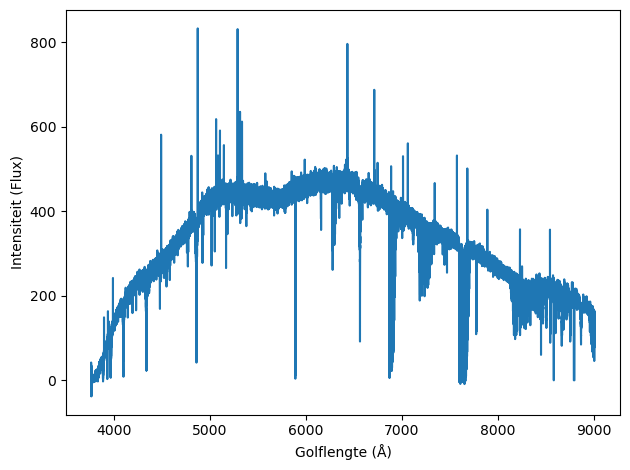

In [4]:
# krijg de data voor datalist[2]
wavelengths, JD, unitx = golflengte_grid(spec, header)

# grafiek van datalist[2]
fig, ax = plt.subplots()
ax.plot(wavelengths, spec)
ax.set_ylabel("Intensiteit (Flux)")
ax.set_xlabel("Golflengte (Å)")
plt.tight_layout()
plt.show()

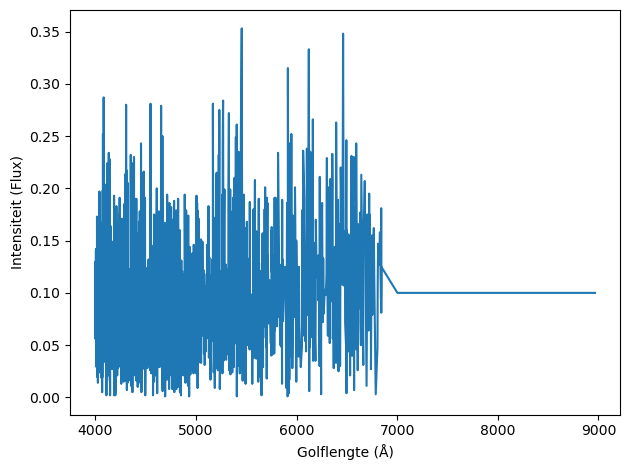

In [5]:
# grafiek van LijnLijst.txt
fig, ax = plt.subplots()
ax.plot(lines[:], weights[:
    ])
ax.set_ylabel("Intensiteit (Flux)")
ax.set_xlabel("Golflengte (Å)")
plt.tight_layout()
plt.show()

# **Radiale Snelheid**

In [6]:
# defineer de formules om de radiale snelheid te berekenen
c = const.c
c_kms = c.value * 10**-3

def doppler(v, lambda0):
    return (v*lambda0)/c_kms + lambda0

# probeer verschillende snelheden en neem de kleinst mogelijke error marge op de lambda
def beste_v(wavelength, spec, lines, v_bereik, v_steps):
    # genereer snelheden om te testen
    v_test = np.arange(v_bereik[0], v_bereik[1] + v_steps, v_steps)
    # maak interpolatiefunctie om te snelheden te testen
    interpolate_functie = interpolate.interp1d(wavelength, spec)
    # variabelen voor de fout-kostfunctie
    wavelengthmax, wavelengthmin = wavelength.max(), wavelength.min()
    error_kost = []

    # bereken de fout voor de snelheden
    for v in v_test:
        # bereken de doppler shift
        lambda_shift = doppler(v, lines)
        # filter enkel lijnen binnen de bereik
        binnen_bereik = binnen_bereik = np.logical_and(lambda_shift >= wavelengthmin, lambda_shift <= wavelengthmax)
        lambda_shift = lambda_shift[binnen_bereik]

        # MSE
        if lambda_shift.size > 0:
            flux_observatie = interpolate_functie(lambda_shift)
            fout_mse = ((flux_observatie)**2).mean()
        else:
            fout_mse = np.inf
        error_kost.append(fout_mse)

    # beste snelheid vinden
    error_kost = np.array(error_kost)
    beste_index = np.argmin(error_kost)
    beste_v = v_test[beste_index]
    min_mse = error_kost[beste_index]

    return v_test, beste_v, error_kost

De onzekerheid door verschillende v te proberen en de beste te vinden is veel kleiner dan de systematische fouten: kalibratie, drift, ruis,...
We concluderen dus, dat de onzekerheid bepaald is door systematische fouten en niet door statistische onzekerheid van de doppler en beste_v 

In [7]:
# test de functie op een data
test = "%s/01053049_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf.fits" %sternaam

test_datalist = glob.glob(test)
test_datalist.sort()
test_spec = pf.getdata(test_datalist[0])
test_header = pf.getheader(test_datalist[0])

test_wl, test_JD, test_unitx = golflengte_grid(test_spec, test_header)

In [73]:
v_t, beste_v_t, error_kost_t = beste_v(test_wl, test_spec, lines, (-30, 50), 0.1)

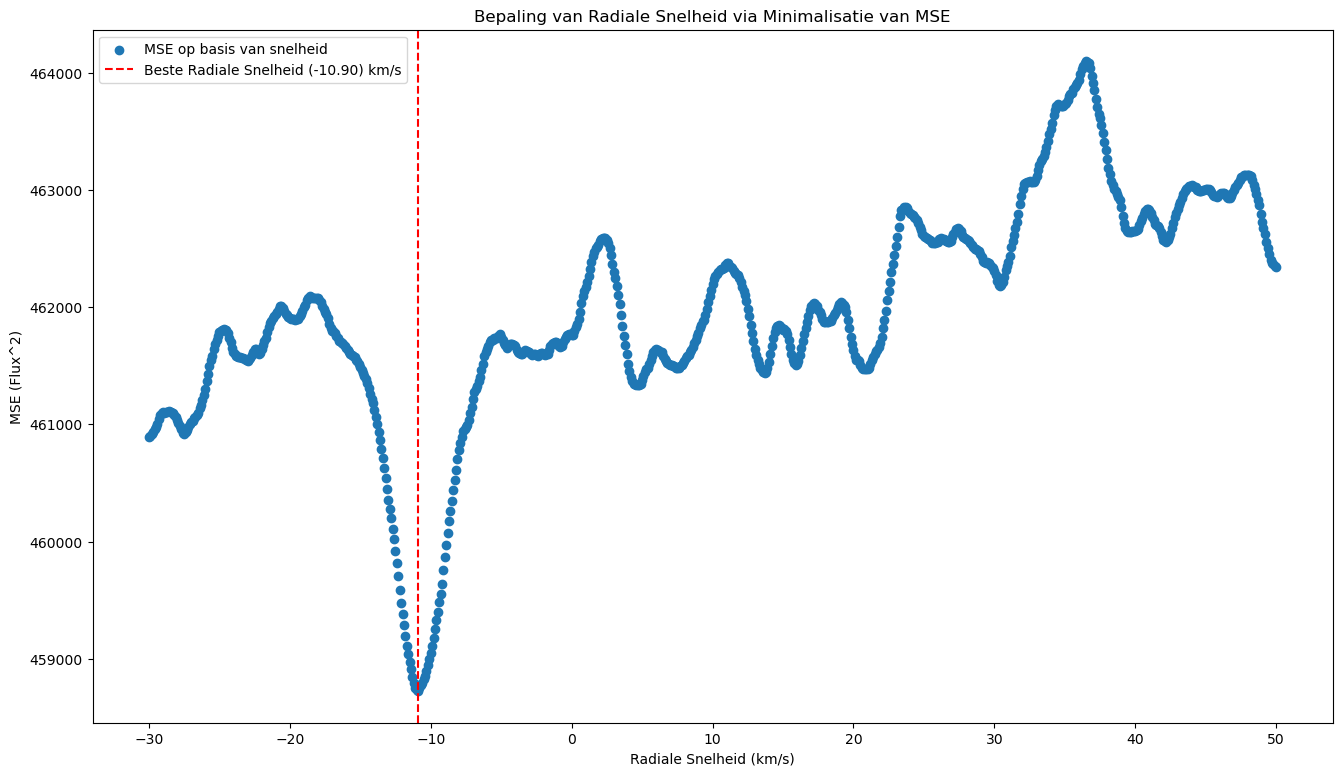

In [74]:
# grafiek van error_kort bepalend van de snelheid
fig, ax = plt.subplots(figsize = (16, 9))
ax.scatter(v_t, error_kost_t, label="MSE op basis van snelheid") # Functie error(v)
plt.axvline(float(beste_v_t), color="red", linestyle="--", label=f"Beste Radiale Snelheid ({beste_v_t:.2f}) km/s")
ax.set_xlabel("Radiale Snelheid (km/s)")
ax.set_ylabel("MSE (Flux^2)")
plt.title("Bepaling van Radiale Snelheid via Minimalisatie van MSE")
plt.legend()
plt.show()

In [75]:
# bepaal radiale snelheid voor alle gekregen data van BD-11_162
snelheid = []
gecorrigeerde_snelheid = [] # Afhankelijk waar de aarde was, verschilt de gemeten snelheid
tijd = []

# itereer over alle data
for data in datalist:
    spec = pf.getdata(data)
    header = pf.getheader(data)

    # bereken alle waarder
    wavelengths, JD, unitx = golflengte_grid(spec, header)
    beste_snelheid = beste_v(wavelengths, spec, lines, (-70, 0), 0.1)[1] # functie returnt 3 waardes en hebben de 2de nodig

    # krijg de correctie van snelheid (zie header; BVCOR)
    correctie_v = header['BVCOR']
    # zet de snelheden en tijden in lijsten'
    snelheid.append(beste_snelheid)
    
    gecorrigeerde_snelheid.append(beste_snelheid - correctie_v)
    tijd.append(JD)

In [76]:
# conversie van Juliaanse tijd
t = Time(tijd, format="jd", scale='tdb')
datum = t.to_datetime()

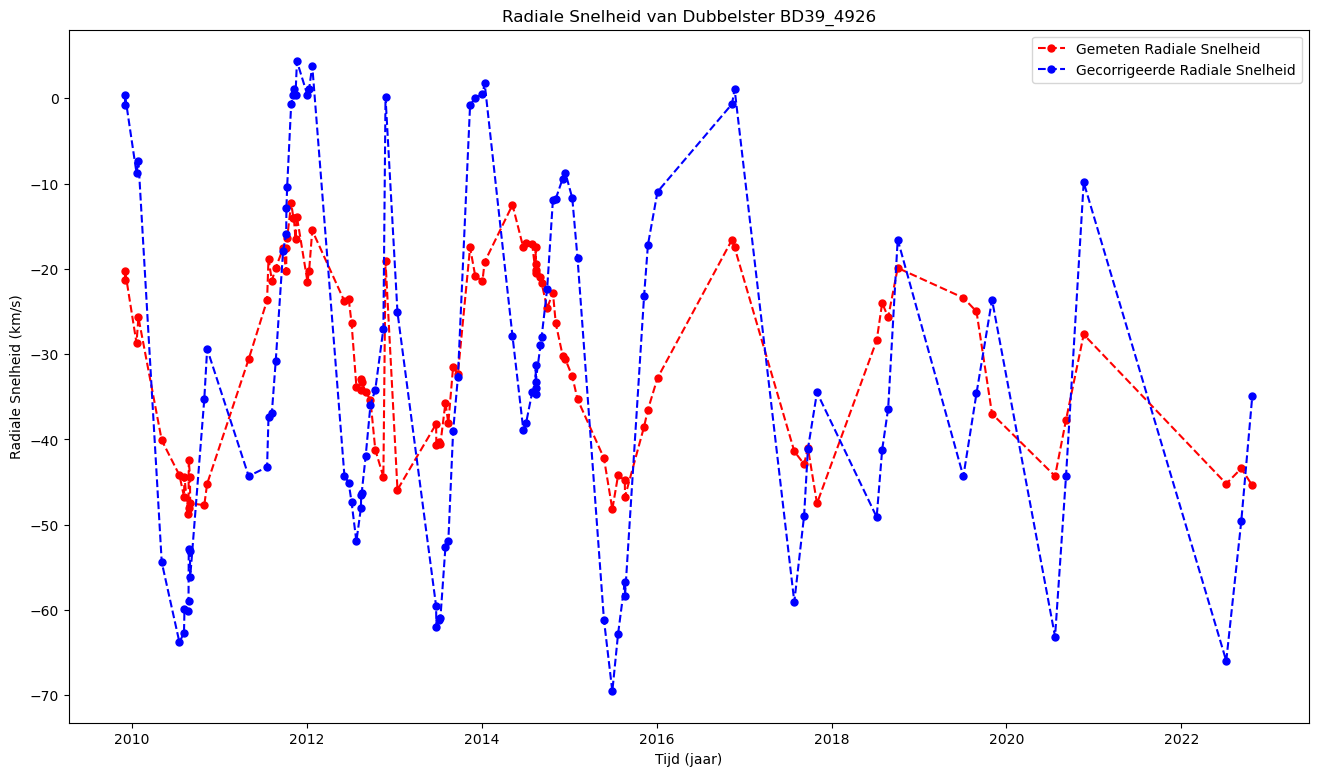

In [77]:
# plot Radiale Snelheid door de tijd heen
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(datum, snelheid, 'o--', color='red', markersize=5, label='Gemeten Radiale Snelheid')
ax.plot(datum, gecorrigeerde_snelheid, 'o--', color='blue', markersize=5, label='Gecorrigeerde Radiale Snelheid')

ax.set_xlabel("Tijd (jaar)")
ax.set_ylabel("Radiale Snelheid (km/s)")
plt.title(f'Radiale Snelheid van Dubbelster {sternaam}')
plt.legend()
plt.show()

### *Periode, Amplitude en massa voor gecorrigeerde snelheden*

In [107]:
# Bereken periode
t = np.array(tijd)
v = np.array(gecorrigeerde_snelheid)

# test periodes tussen 0.5 en 1000 dagen
frequenties = np.linspace(1/10000000.0, 1, 100000)

# bereken het periode-gram
power = LombScargle(t, v).power(frequenties)
# neem de beste frequentie (hoogste piek)
beste_freq = frequenties[np.argmax(power)]
# periode = 1/freq
P_dagen = 1.0/beste_freq
sigma_P_dagen = LombScargle(t, v).false_alarm_probability(np.max(power)) # niet zeker, online gevonden
print(f"Berekende Periode (P): {P_dagen:.4f} dagen") # zie juist onder, onzekerheid is kleiner dan 10**-20
# print(f"Berekende Periode (P): {P_dagen:.4f} +/- {sigma_P_dagen:.23f} dagen")

Berekende Periode (P): 366.2833 dagen


In [108]:
# model voor fit functie
def radiale_snelheid_fit(tijd, amplitude, t0, b, P):
    # v(t) = A*sin(2pi/P * (t-t0)) + b
    # P = P_dagen
    return amplitude * np.sin((2*np.pi / P) * (tijd - t0)) + b

amplitude_gok = (v.max() - v.min())/2
b_gok = np.median(v)
t0_gok = t[np.argmin(v)] # Datum van het minimum

In [116]:
# calculatie
# popt, pcov = curve_fit(radiale_snelheid_fit, t, v, p0=[amplitude_gok, t0_gok, b_gok, P_dagen])
popt, pcov = curve_fit(radiale_snelheid_fit, t, v, p0=[amplitude_gok, b_gok, t0_gok, P_dagen])
onzekerheid = np.sqrt(np.diag(pcov))

In [117]:
# popt, pcov = curve_fit(radiale_snelheid_fit, t, v, p0=[16, t0_gok, b_gok, 800])
# onzekerheid = np.sqrt(np.diag(pcov))

In [118]:
# Bekijk de fit
amplitude, t0, b, P_fit = popt
sigma_A, sigma_t0, sigma_b, sigma_P_fit = onzekerheid

print(f"Amplitude (A): {amplitude:.4f} +/- {sigma_A:.4f} km/s")
# print(f"t0: {t0:.4f} +/- {sigma_t0:0.4f} k")
print(f"Systemische Snelheid (b): {b:.4f} +/- {sigma_b:.4f} km/s")
print(f"Periode (dagen): {P_fit:.4f} +/- {sigma_P_fit:.4f} dagen")

Amplitude (A): 25.4729 +/- 1.8341 km/s
Systemische Snelheid (b): -28.8570 +/- 1.5078 km/s
Periode (dagen): 366.4456 +/- 1.1412 dagen


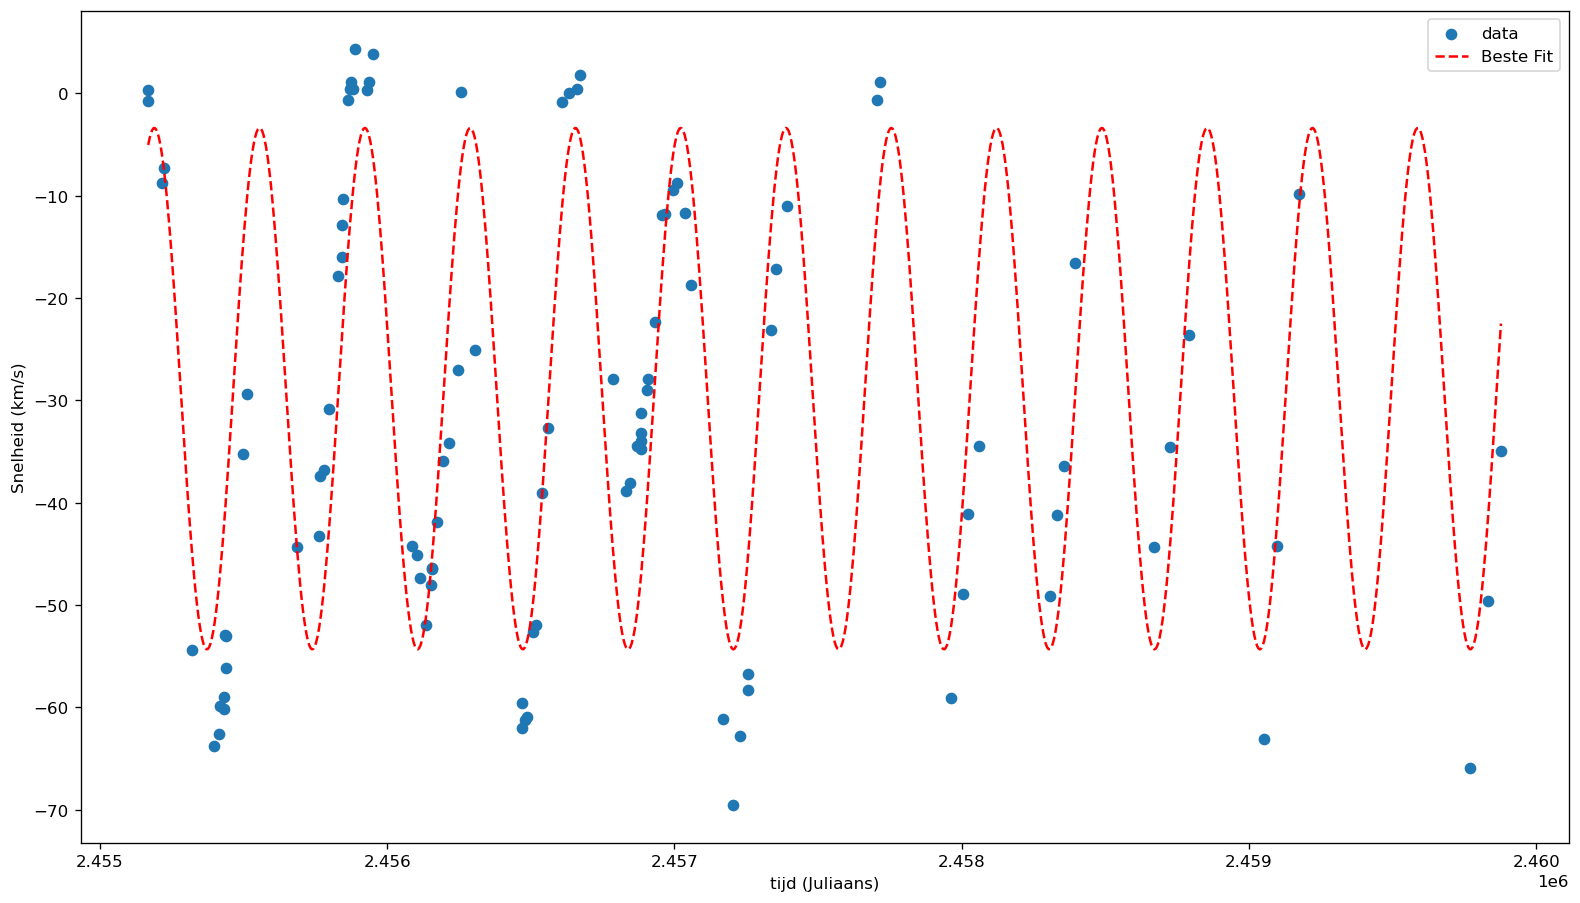

In [119]:
# grafiek van schatting
fig, ax = plt.subplots(dpi=120, figsize=(16, 9))

t_fit = np.linspace(t.min(), t.max(), 1000)
ax.scatter(t, v, label="data")
ax.plot(t_fit,
        radiale_snelheid_fit(t_fit, amplitude, t0, b, P_fit),
        label="Beste Fit",
        color = 'red',
        linestyle='--')

ax.set_ylabel("Snelheid (km/s)")
ax.set_xlabel("tijd (Juliaans)")
plt.legend()
plt.show()

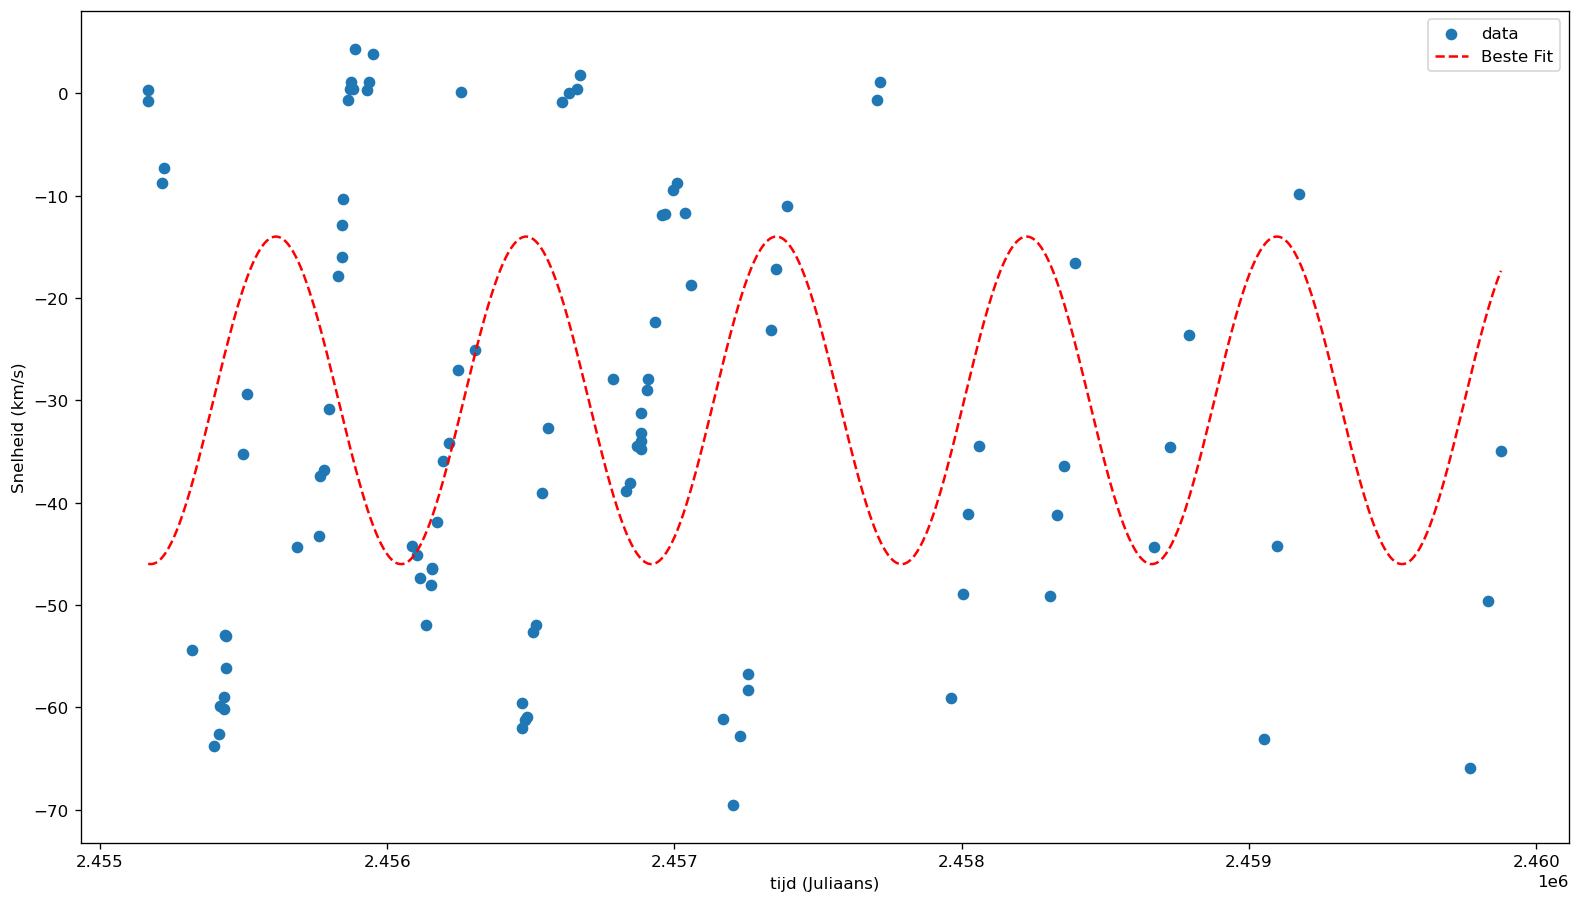

In [120]:
# grafiek van schatting
fig, ax = plt.subplots(dpi=120, figsize=(16, 9))

t_fit = np.linspace(t.min(), t.max(), 1000)
ax.scatter(t, v, label="data")
ax.plot(t_fit,
        radiale_snelheid_fit(t_fit, 16, 2451040, -30, 871),
        label="Beste Fit",
        color = 'red',
        linestyle='--')

ax.set_ylabel("Snelheid (km/s)")
ax.set_xlabel("tijd (Juliaans)")
plt.legend()
plt.show()

### *Periode, Amplitude en massa voor niet gecorrigeerde snelheid*
ng = niet gecorrigeerd

In [85]:
# Bereken periode
t_ng = np.array(tijd)
v_ng = np.array(snelheid)
# test periodes tussen 0.5 en 1000 dagen
frequenties_ng = np.linspace(1/10000.0, 1, 100000)

# bereken het periode-gram
power_ng = LombScargle(t_ng, v_ng).power(frequenties_ng)
# neem de beste frequentie (hoogste piek)
beste_freq_ng = frequenties_ng[np.argmax(power_ng)]
# periode = 1/freq
P_dagen_ng = 1.0/beste_freq_ng
sigma_P_dagen_ng = LombScargle(t_ng, v_ng).false_alarm_probability(np.max(power_ng)) # niet zeker, online gevonden
print(f"Berekende Periode (P): {P_dagen_ng:.4f} dagen") # zie juist onder, onzekerheid is kleiner dan 10**-20
# print(f"Berekende Periode (P): {P_dagen_ng:.4f} +/- {sigma_P_dagen_ng:.28f} dagen")

Berekende Periode (P): 869.6367 dagen


In [86]:
amplitude_ng_gok = (v_ng.max() - v_ng.min())/2
b_ng_gok = np.median(v_ng)
t0_ng_gok = t_ng[np.argmin(v_ng)] # Datum van het minimum

In [87]:
# calculatie
popt_ng, pcov_ng = curve_fit(radiale_snelheid_fit, t_ng, v_ng, p0=[amplitude_ng_gok, t0_ng_gok, b_ng_gok, P_dagen_ng])
onzekerheid_ng = np.sqrt(np.diag(pcov_ng))

In [88]:
# Bekijk de fit
amplitude_ng, t0_ng, b_ng, P_dagen_ng_fit = popt_ng
sigma_ng_A, sigma_ng_t0, sigma_ng_b, sigma_P_dagen_ng_fit = onzekerheid_ng

print(f"Amplitude (A_ng): {amplitude_ng:.4f} +/- {sigma_ng_A:.4f} km/s")
# print(f"t0: {t0_ng:.4f} +/- {sigma_ng_t0:0.4f} k")
print(f"Systemische Snelheid (b_ng): {b_ng:.4f} +/- {sigma_ng_b:.4f} km/s")
print(f"Periode (dagen): {P_dagen_ng_fit:.4f} +/- {sigma_P_dagen_ng_fit:.4f} dagen")

Amplitude (A_ng): 15.2062 +/- 0.4599 km/s
Systemische Snelheid (b_ng): -30.0385 +/- 0.3242 km/s
Periode (dagen): 870.0564 +/- 3.4080 dagen


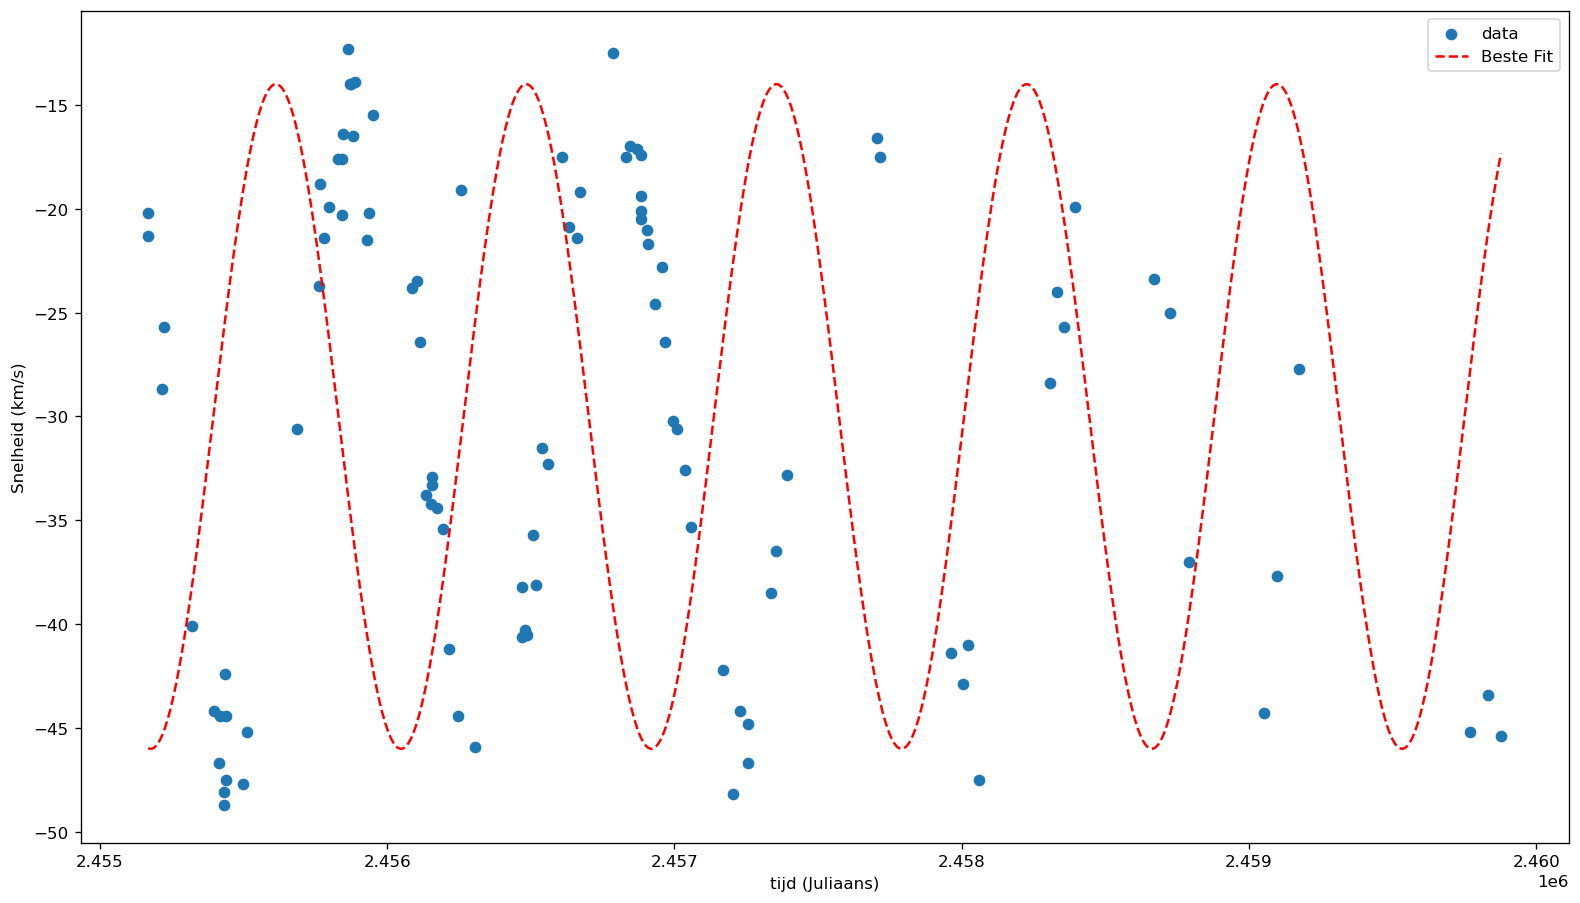

In [89]:
# grafiek van schatting
fig, ax = plt.subplots(dpi=120, figsize=(16, 9))

t_ng_fit = np.linspace(t_ng.min(), t_ng.max(), 1000)
ax.scatter(t_ng, v_ng, label="data")
ax.plot(t_ng_fit,
        radiale_snelheid_fit(t_ng_fit, 16, 2451040, -30, 871),
        label="Beste Fit",
        color = 'red',
        linestyle='--')

ax.set_ylabel("Snelheid (km/s)")
ax.set_xlabel("tijd (Juliaans)")
plt.legend()
plt.show()

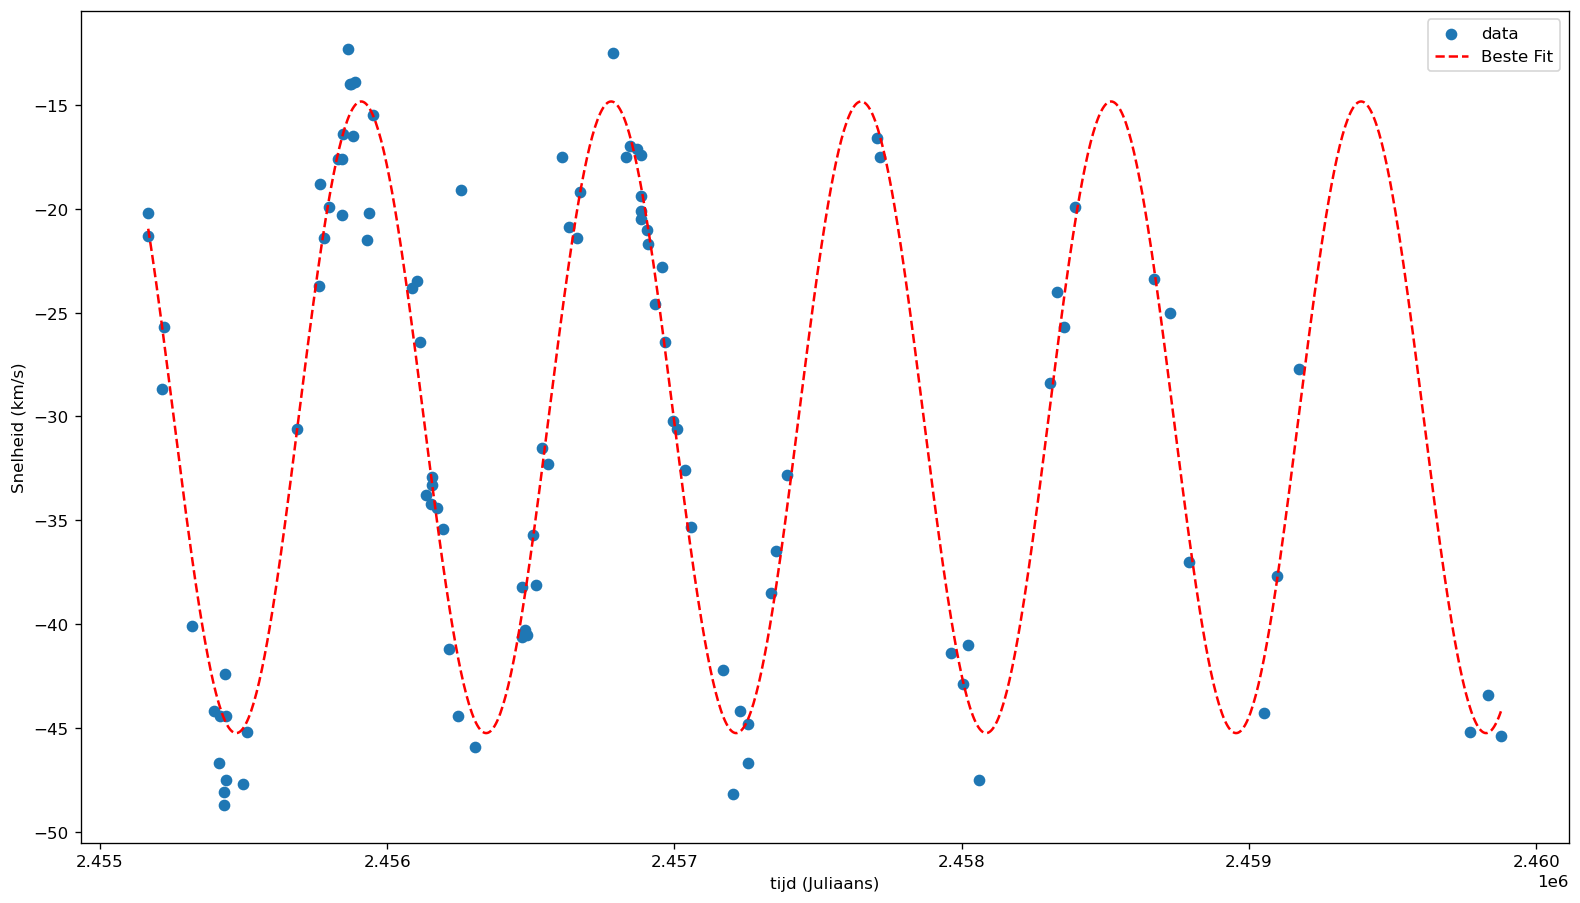

In [91]:
fig, ax = plt.subplots(dpi=120, figsize=(16, 9))

t_ng_fit = np.linspace(t_ng.min(), t_ng.max(), 1000)
ax.scatter(t_ng, v_ng, label="data")
ax.plot(t_ng_fit,
        radiale_snelheid_fit(t_ng_fit, amplitude_ng, t0_ng, b_ng, P_dagen_ng_fit),
        label="Beste Fit",
        color = 'red',
        linestyle='--')

ax.set_ylabel("Snelheid (km/s)")
ax.set_xlabel("tijd (Juliaans)")
plt.legend()
plt.show()

# **Massa bepaling**
### *Voor gecorrigeerde snelheid*

In [92]:
G = const.G.value
m_zon_kg = const.M_sun.value

# verander naar SI-eenheden
P_seconden = P_dagen * 60 * 60 * 24 # 60s * 60min * 24u = dag
sigma_P_seconden = sigma_P_dagen * 60 * 60 * 24
A_ms = amplitude * 10**3
sigma_A_ms = sigma_A * 10**3
m1_kg = 0.6 * m_zon_kg
sigma_m1_kg = 0.1 * m_zon_kg

# functies voor berekeningen
def massa_functie(periode_sec, K_ms):
    return (periode_sec / (2 * np.pi)) * (K_ms**3)

def onzekerheid_massa_functie(A_ms, simga_A_ms, P_sec, sigma_P_sec):
    # sigma_f(M)^2 = (v**3/2piG * sigmaP)^2 + (3pi v**2 / 2piG * sigmav)^2
    onzekerheid_f_M = ((A_ms**3 * sigma_P_sec) / (2*np.pi*G))**2 + ((3*P_sec*A_ms**2 *sigma_A_ms) / (2*np.pi*G))**2
    sigma_f_M = np.sqrt(onzekerheid_f_M)
    sigma_f_M_zonnemassa = sigma_f_M / m_zon_kg
    return sigma_f_M, sigma_f_M_zonnemassa


def nulwaarden(a, b, c, d):
    wortels = np.roots([a, b, c, d])
    reele_wortels = wortels[np.isreal(wortels)].real
    return reele_wortels

def massa2(f_M_overG, m1, hoek):
    # f(M)/sin(i)**3 = m2**3 / (m1 + m2)**2
    # neem f(m)/sini**3 als B en m1 als A
    # x**3 - Bx**2 - 2ABx - A**2B ; met x = m2
    sin_i = np.sin(hoek)
    B = f_M_overG / (sin_i**3)
    A = m1
    a = 1.0; b = -B; c = -2*A*B; d = -(A**2) * B
    return nulwaarden(a, b, c, d)

def onzekerheid_m2(m2_kg, m1_kg, inclinatie, sigma_f_M):
    # zet hoek van graden naar radialen
    inclinatie = np.deg2rad(inclinatie)
    sin_i = np.sin(inclinatie)
    
    # we doen partiele afgeleiden van delta_m2/delta_f(m) over f(m) = sin**3 m2**3/(m1+m2)**2
    # voor partiele afgeleide van delta_m2/delta_hoek, delta hoek is ongeveer 0
    # we krijgen dus voor delta_m2/delta_f(m) => 1 = m2' * (sin**3 3*m_2**2 - 2(m1+m2)* sin**3 m2**3)/ (m1+m2)**4
    # we zetten m_2' apart en krijgen we m_2' = (m1+m2)**4 / (3 m2**2 sin**3 - (2(m1+m2) sin**3 m_2**3))
    teller = (m1_kg + m2_kg)**4
    noemer_1 = 3*m2_kg**2*sin_i**3
    noemer_2 = 2*(m1_kg + m2_kg) * sin_i**3 * m2_kg**3
    noemer = noemer_1 - noemer_2
    # we nemen geen kwadraat of wortel want we hebben maar 1 onzekerheid nl. f(m)
    
    sigma_m2 = (teller / noemer) * sigma_f_M
    sigma_m2_zonnemassa = sigma_m2 / m_zon_kg

    return abs(sigma_m2), abs(sigma_m2_zonnemassa)

In [93]:
# berekeningen f(M)
f_M = massa_functie(P_seconden, A_ms)
f_M_overG = f_M / G
f_M_zonnemassa = f_M_overG / m_zon_kg

# onzekerheid f(M) bij 90graden
sigma_f_M_kg, sigma_f_M_zonnemassa = onzekerheid_massa_functie(A_ms, sigma_A_ms, P_seconden, sigma_P_seconden)

# minimum massa m2 (bij i = 90 graden)
i_min_rad = np.deg2rad(90.0)
m2_min_kg = massa2(f_M_overG, m1_kg, i_min_rad)
m2_min_zonnemassa = m2_min_kg / m_zon_kg

# onzekerheid voor minimum massa m2
sigma_m2_min_kg, sigma_m2_min_zonnemassa = onzekerheid_m2(m2_min_kg, m1_kg, 90, sigma_f_M_kg)

print(f"Massafunctie f(M): {f_M_zonnemassa:.4f} ± {sigma_f_M_zonnemassa:.4f} M_zon")
print(f"Minimum m_2 (M_zon): {float(m2_min_zonnemassa[0]):.4f} ± {float(sigma_m2_min_zonnemassa[0]):.4f} M_zon")

Massafunctie f(M): 0.3289 ± 0.1150 M_zon
Minimum m_2 (M_zon): 0.9076 ± 0.2635 M_zon


In [94]:
# Grafiek maken m2 per inclinatie
m2_zonnemassa_lijst = []
sigma_m2_zonnemassa_lijst = []

# hoeken generen voor grafiek
inclinatie_graden = np.linspace(40, 90, 25) # kan niet delen door 0, dus begin altijd > 0
inclinatie_rad = np.deg2rad(inclinatie_graden)

# massa's berekenen
for hoek in inclinatie_rad:
    # bereken massa
    massa2_h = massa2(f_M_overG, m1_kg, hoek)
    m2_zonnemassa_lijst.append(massa2_h / m_zon_kg)
    # bereken onzekerheid
    simga_m2_inc, sigma_m2_zonnemassa_inc = onzekerheid_m2(massa2_h, m1_kg, np.rad2deg(hoek), sigma_f_M_kg)
    sigma_m2_zonnemassa_lijst.append((sigma_m2_zonnemassa_inc))

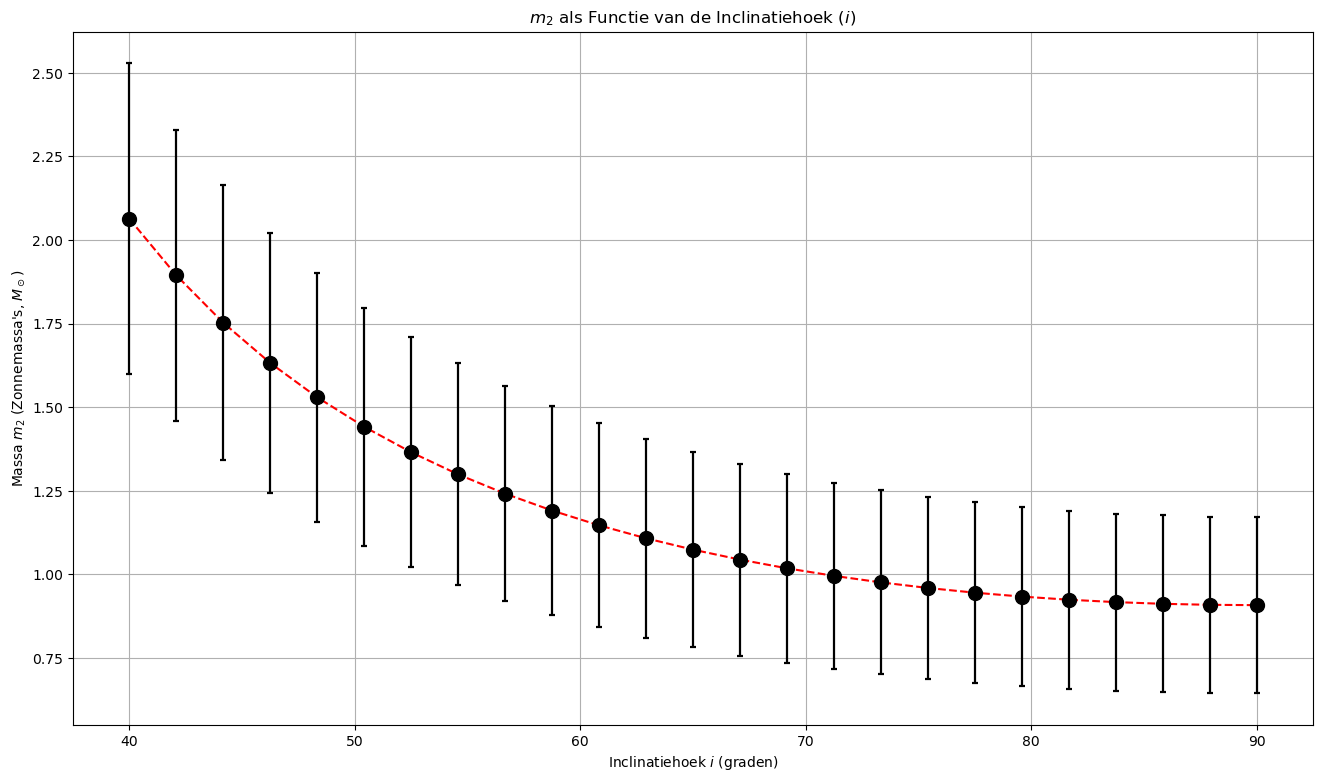

In [95]:
# maak grafiek
fig, ax = plt.subplots(figsize = (16, 9))

# Plot de data met errorbars
ax.errorbar(
    np.array(inclinatie_graden).flatten(),
    np.array(m2_zonnemassa_lijst).flatten(),
    yerr=np.array(sigma_m2_zonnemassa_lijst).flatten(),
    linestyle='',
    color='black',
    ecolor='black',
    marker="o",
    markersize=10,
    capsize=2,
    capthick=1.6,
    linewidth=1.6,
)

# plot stippenlijn door de data
ax.plot(inclinatie_graden, m2_zonnemassa_lijst, color='red', linestyle='--')



plt.title('$m_2$ als Functie van de Inclinatiehoek ($i$)')
ax.set_xlabel('Inclinatiehoek $i$ (graden)')
ax.set_ylabel('Massa $m_2$ (Zonnemassa\'s, $M_\\odot$)')

plt.grid(True)
plt.show()

# **Massa Bepaling**
### *voor niet gecorrigeerde snelheid*

In [96]:
# verander naar SI-eenheden
P_seconden_ng = P_dagen_ng * 60 * 60 * 24 # 60s * 60min * 24u = dag
sigma_P_seconden_ng = sigma_P_dagen_ng * 60 * 60 * 24
A_ms_ng = amplitude_ng * 10**3
sigma_A_ms_ng = sigma_ng_A * 10**3
m1_kg = 0.6 * m_zon_kg
sigma_m1_kg = 0.1 * m_zon_kg

In [97]:
# berekeningen f(M); de functies veranderen niet voor gecorrigeerde of niet snelheid
f_M_ng = massa_functie(P_seconden_ng, A_ms_ng)
f_M_overG_ng = f_M_ng / G
f_M_zonnemassa_ng = f_M_overG_ng / m_zon_kg

# onzekerheid f(M) bij 90graden
sigma_f_M_kg_ng, sigma_f_M_zonnemassa_ng = onzekerheid_massa_functie(A_ms_ng, sigma_A_ms_ng, P_seconden_ng, sigma_P_seconden_ng)

# minimum massa m2 (bij i = 90 graden)
m2_min_kg_ng = massa2(f_M_overG_ng, m1_kg, i_min_rad)
m2_min_zonnemassa_ng = m2_min_kg_ng / m_zon_kg

# onzekerheid voor minimum massa m2
sigma_m2_min_kg_ng, sigma_m2_min_zonnemassa_ng = onzekerheid_m2(m2_min_kg_ng, m1_kg, 90, sigma_f_M_kg_ng)

print(f"Massafunctie f(M): {f_M_zonnemassa_ng:.4f} ± {sigma_f_M_zonnemassa_ng:.4f} M_zon")
print(f"Minimum m_2 (M_zon): {float(m2_min_zonnemassa_ng[0]):.4f} ± {float(sigma_m2_min_zonnemassa_ng[0]):.4f} M_zon")

Massafunctie f(M): 0.3168 ± 0.1496 M_zon
Minimum m_2 (M_zon): 0.8889 ± 0.3515 M_zon


In [98]:
# Grafiek maken m2 per inclinatie
m2_zonnemassa_lijst_ng = []
sigma_m2_zonnemassa_lijst_ng = []

# hoeken generen voor grafiek
inclinatie_graden_ng = np.linspace(75, 90, 2) # kan niet delen door 0, dus begin altijd > 0
inclinatie_rad_ng = np.deg2rad(inclinatie_graden_ng)

# massa's berekenen
for hoek in inclinatie_rad_ng:
    # bereken massa
    massa2_h_ng = massa2(f_M_overG_ng, m1_kg, hoek)
    m2_zonnemassa_lijst_ng.append(massa2_h_ng / m_zon_kg)
    # bereken onzekerheid
    simga_m2_inc_ng, sigma_m2_zonnemassa_inc_ng = onzekerheid_m2(massa2_h_ng, m1_kg, np.rad2deg(hoek), sigma_f_M_kg_ng)
    sigma_m2_zonnemassa_lijst_ng.append((sigma_m2_zonnemassa_inc_ng))

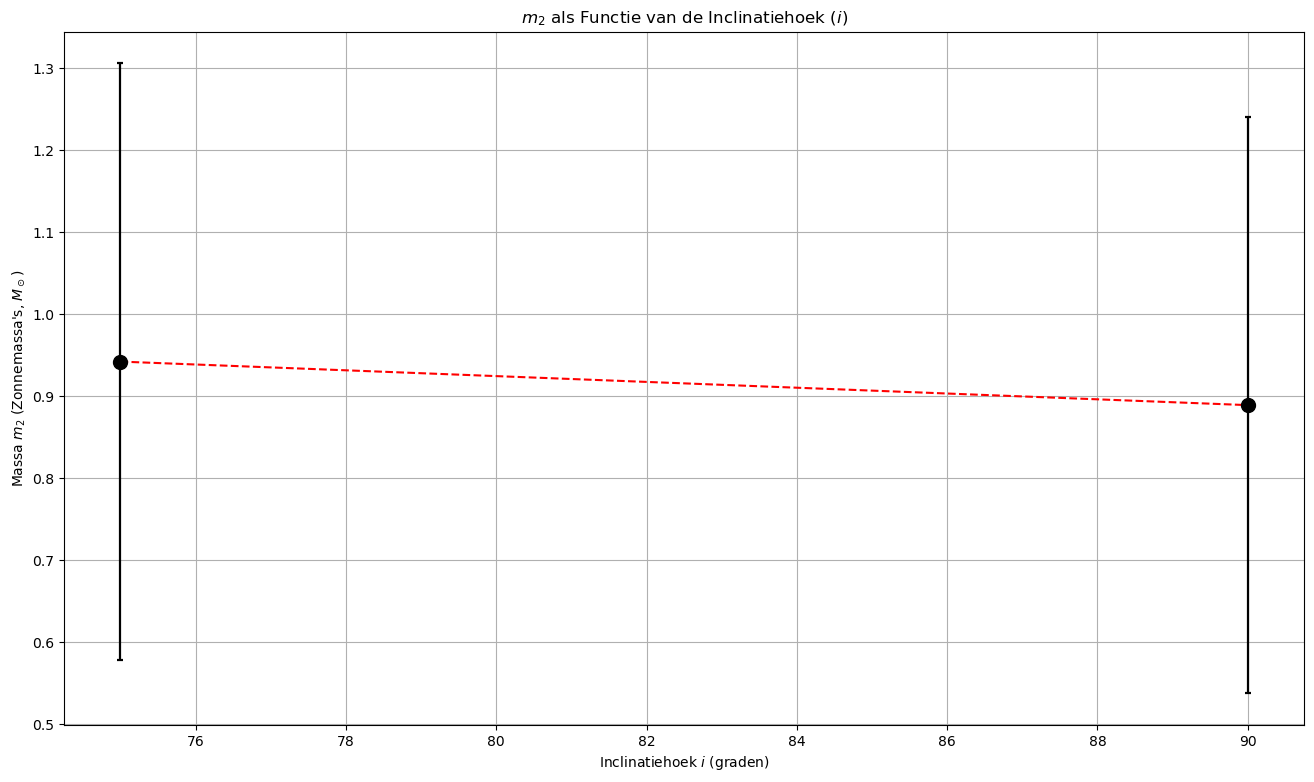

In [99]:
# maak grafiek
fig, ax = plt.subplots(figsize = (16, 9))

# Plot de data met errorbars
ax.errorbar(
    np.array(inclinatie_graden_ng).flatten(),
    np.array(m2_zonnemassa_lijst_ng).flatten(),
    yerr=np.array(sigma_m2_zonnemassa_lijst_ng).flatten(),
    linestyle='',
    color='black',
    ecolor='black',
    marker="o",
    markersize=10,
    capsize=2,
    capthick=1.6,
    linewidth=1.6,
)

# plot stippenlijn door de data
ax.plot(inclinatie_graden_ng, m2_zonnemassa_lijst_ng, color='red', linestyle='--')



plt.title('$m_2$ als Functie van de Inclinatiehoek ($i$)')
ax.set_xlabel('Inclinatiehoek $i$ (graden)')
ax.set_ylabel('Massa $m_2$ (Zonnemassa\'s, $M_\\odot$)')

plt.grid(True)
plt.show()